## Importando bibliotecas

In [11]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import sys
from util import *
import gc
import pickle

import statsmodels as sms
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white

import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

## Lendo os dados

In [12]:
df = pd.read_excel("../data/raw/base_plano_de_saude.xlsx")
df.head(10)

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude
0,19,Feminino,27.900,0,Sim,Centro,1688.492400
1,18,Masculino,33.770,1,Não,Sudeste,172.555230
2,28,Masculino,33.000,3,Não,Sudeste,444.946200
3,33,Masculino,22.705,0,Não,Norte,2198.447061
4,32,Masculino,28.880,0,Não,Norte,386.685520
5,31,Feminino,25.740,0,Não,Sudeste,375.662160
6,46,Feminino,33.440,1,Não,Sudeste,824.058960
7,37,Feminino,27.740,3,Não,Norte,728.150560
8,37,Masculino,29.830,2,Não,Nordeste,640.641070
9,60,Feminino,25.840,0,Não,Norte,2892.313692


## Entendimento dos dados e do target

In [13]:
df.shape

(1338, 7)

In [14]:
metadados = generate_metadata(df=df, targets=['Custo_Saude'], orderby='CARDINALIDADE')
metadados

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,Custo_Saude,Target,0,0.0,1337,float64
1,IMC,Explicativa,0,0.0,548,float64
2,Idade,Explicativa,0,0.0,47,int64
3,Qte_Filhos,Explicativa,0,0.0,6,int64
4,Região,Explicativa,0,0.0,4,object
5,Sexo,Explicativa,0,0.0,2,object
6,Fumante,Explicativa,0,0.0,2,object


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Idade,1338.0,39.207025,14.049960,18.00000,27.000000,39.0000,51.000000,64.000000
IMC,1338.0,30.663397,6.098187,15.96000,26.296250,30.4000,34.693750,53.130000
Qte_Filhos,1338.0,1.094918,1.205493,0.00000,0.000000,1.0000,2.000000,5.000000
Custo_Saude,1338.0,1327.042227,1211.001124,112.18739,474.028715,938.2033,1663.991252,6377.042801


## Feature Engineering

In [16]:
def classificar_imc(df, coluna='IMC'):
    condicoes = [
        (df[coluna] >= 18.5) & (df[coluna] <= 24.9),
        (df[coluna] >= 25.0) & (df[coluna] <= 29.9),
        (df[coluna] >= 30.0) & (df[coluna] <= 34.9),
        (df[coluna] >= 35.0) & (df[coluna] <= 39.9),
        (df[coluna] >= 40.0)
    ]

    categorias = [
        'Peso Normal',
        'Acima do Peso',
        'Obesidade Grau I',
        'Obesidade Grau II',
        'Obesidade Grau III'
    ]

    df['IMC_Classificacao'] = np.select(condicoes, categorias, default='Abaixo do Peso')
    return df

In [17]:
df = classificar_imc(df)

In [18]:
df['ordem_IMC'] = df['IMC_Classificacao'].map({
    'Abaixo do Peso': 1,
    'Peso Normal': 2,
    'Acima do Peso': 3,
    'Obesidade Grau I': 4,
    'Obesidade Grau II': 5,
    'Obesidade Grau III': 6
})

In [19]:
df['IMC_Classificacao_e_Fumante'] = df['IMC_Classificacao'] + df['Fumante']

In [20]:
def mapear_fumante(valor):
    if valor == 'Sim':
        return 1
    else:
        return 0


In [21]:
df['Fumante_Sim'] = df['Fumante'].apply(mapear_fumante)

In [22]:
df['ordem_IMC_e_Fumante_Sim'] = df['ordem_IMC']  * df['Fumante_Sim']

In [23]:
metadados = generate_metadata(df=df, targets=['Custo_Saude'], orderby='CARDINALIDADE')
metadados

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,Custo_Saude,Target,0,0.0,1337,float64
1,IMC,Explicativa,0,0.0,548,float64
2,Idade,Explicativa,0,0.0,47,int64
3,IMC_Classificacao_e_Fumante,Explicativa,0,0.0,12,object
4,ordem_IMC_e_Fumante_Sim,Explicativa,0,0.0,7,int64
5,Qte_Filhos,Explicativa,0,0.0,6,int64
6,ordem_IMC,Explicativa,0,0.0,6,int64
7,IMC_Classificacao,Explicativa,0,0.0,6,object
8,Região,Explicativa,0,0.0,4,object
9,Sexo,Explicativa,0,0.0,2,object


In [24]:
df.head()

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude,IMC_Classificacao,ordem_IMC,IMC_Classificacao_e_Fumante,Fumante_Sim,ordem_IMC_e_Fumante_Sim
0,19,Feminino,27.900,0,Sim,Centro,1688.492400,Acima do Peso,3,Acima do PesoSim,1,3
1,18,Masculino,33.770,1,Não,Sudeste,172.555230,Obesidade Grau I,4,Obesidade Grau INão,0,0
2,28,Masculino,33.000,3,Não,Sudeste,444.946200,Obesidade Grau I,4,Obesidade Grau INão,0,0
3,33,Masculino,22.705,0,Não,Norte,2198.447061,Peso Normal,2,Peso NormalNão,0,0
4,32,Masculino,28.880,0,Não,Norte,386.685520,Acima do Peso,3,Acima do PesoNão,0,0


## Análises univariadas e bivariadas

🔹 Análise Univariada - Variáveis Categóricas


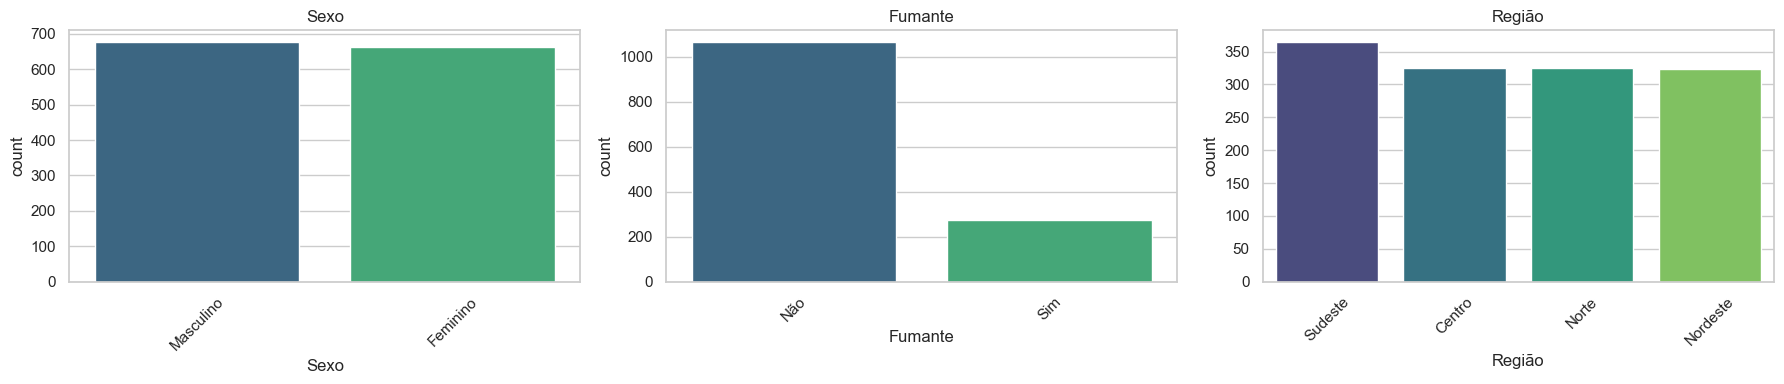

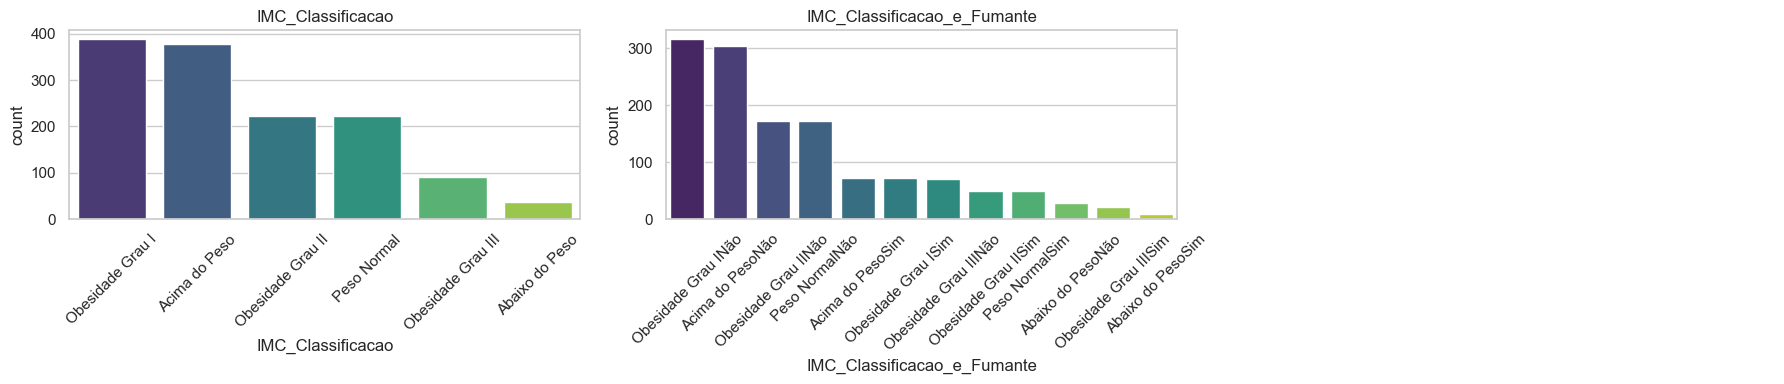

🔹 Análise Univariada - Variáveis Numéricas


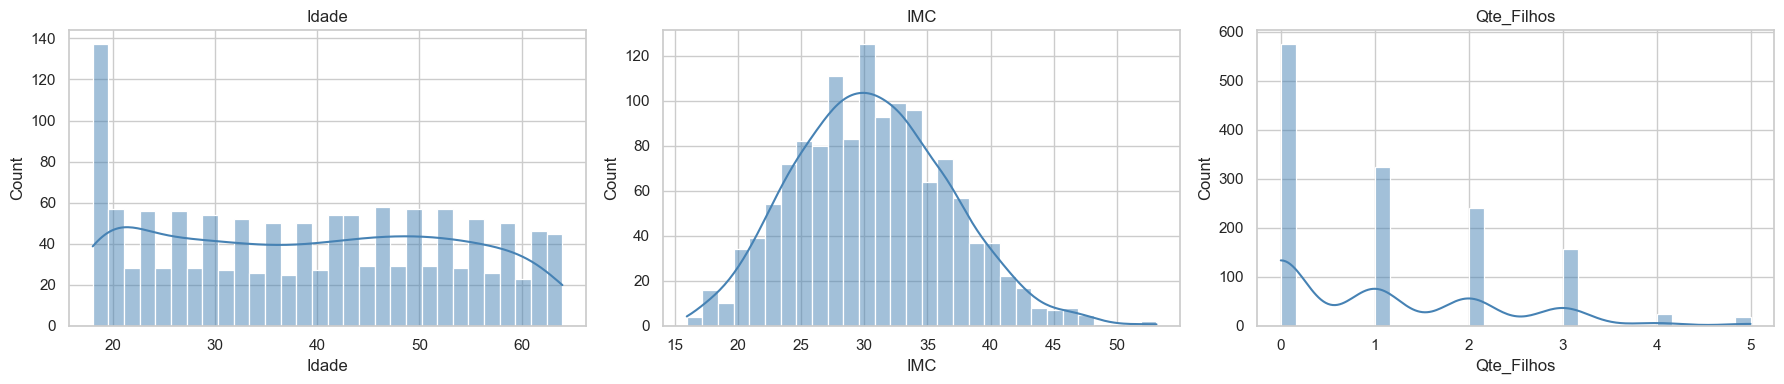

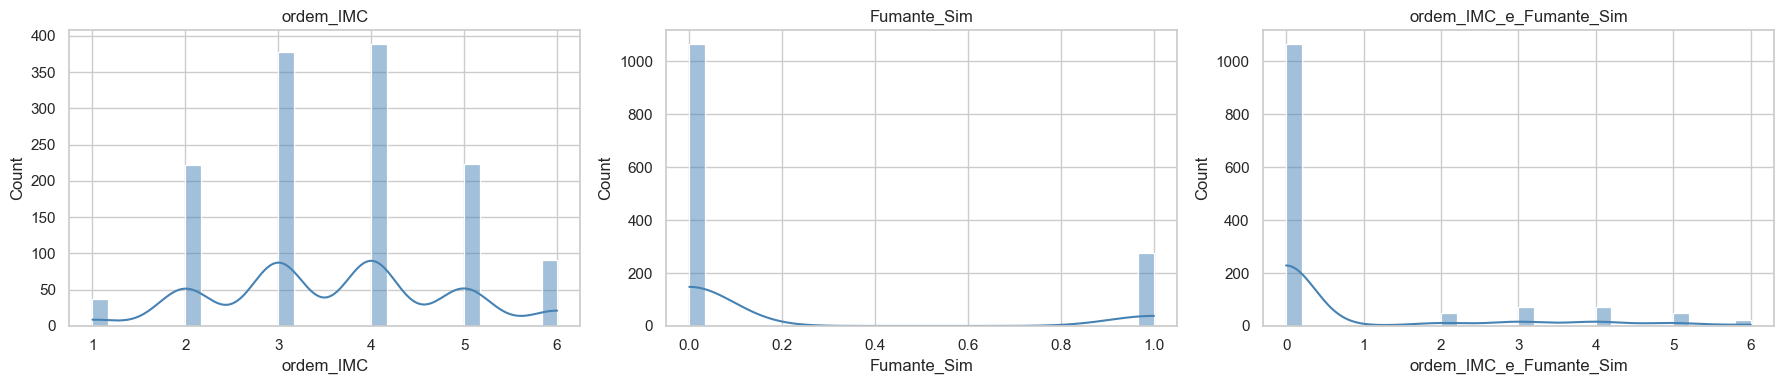

In [25]:
import math
# Variáveis de interesse
target = 'Custo_Saude'

categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_vars = df.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Remove o target da lista de variáveis categóricas
if target in numerical_vars:
    numerical_vars.remove(target)

# --------------------
# Execução das análises
# --------------------

print("🔹 Análise Univariada - Variáveis Categóricas")
univariate_categorical(df, categorical_vars)

print("🔹 Análise Univariada - Variáveis Numéricas")
univariate_numerical(df, numerical_vars)


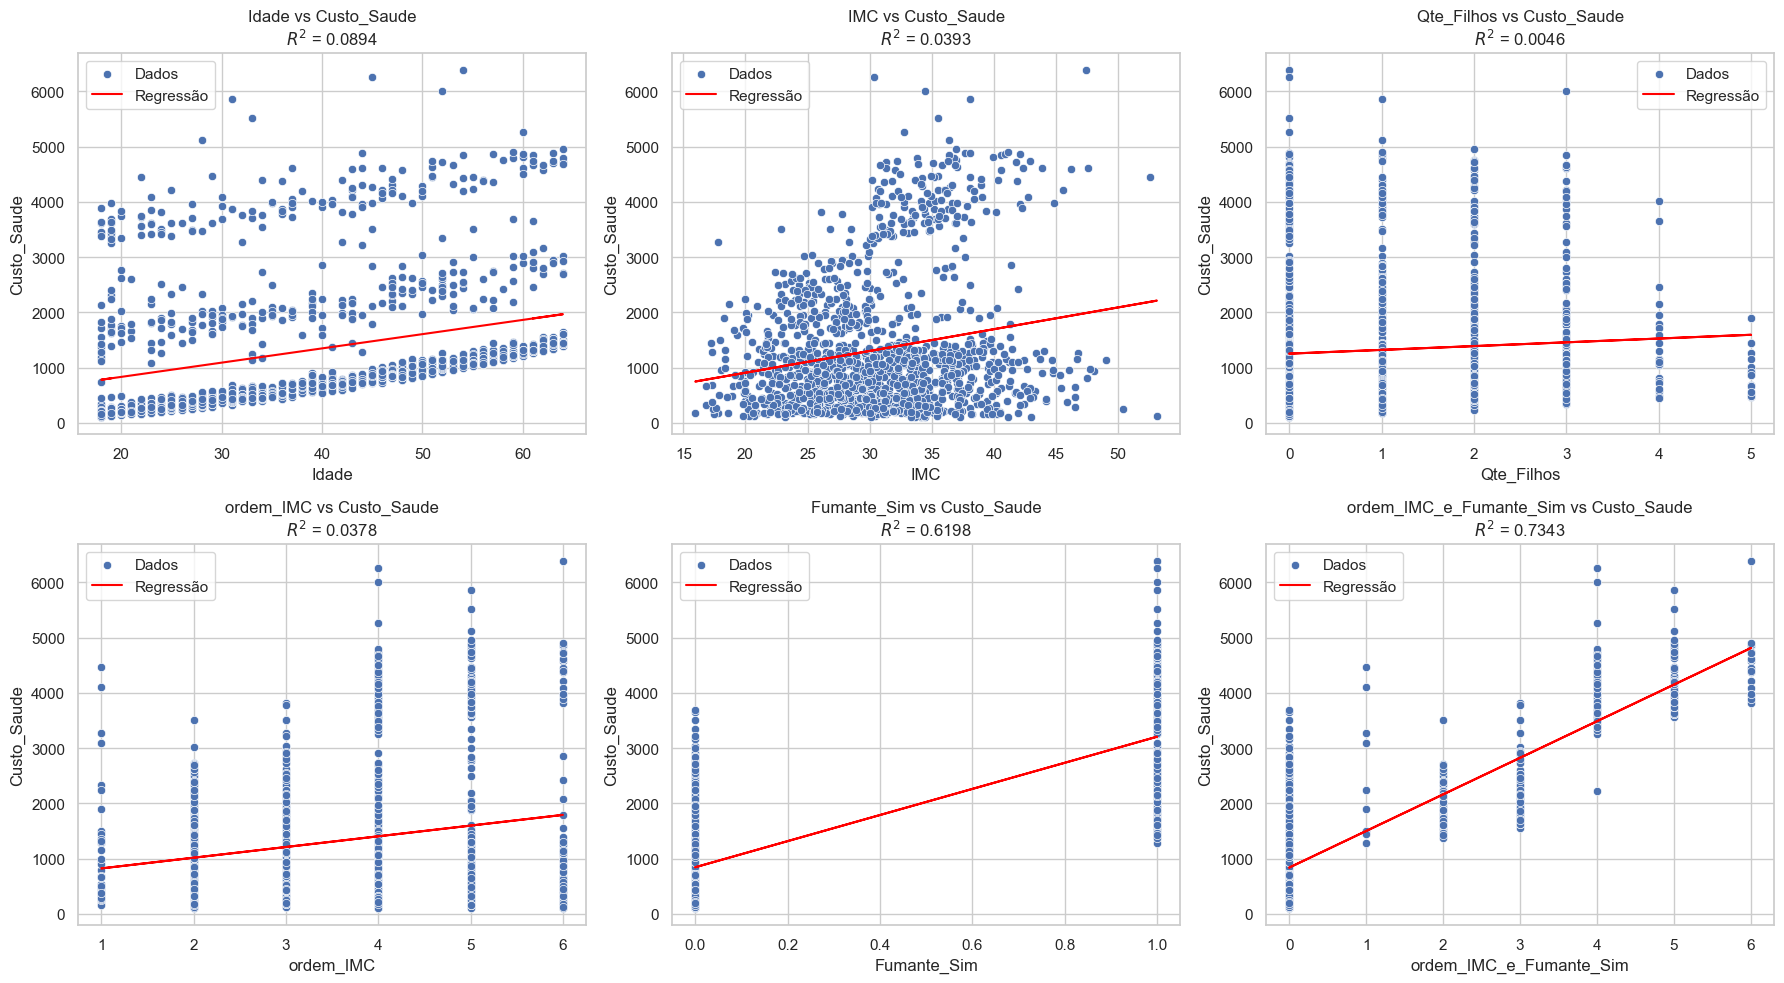

In [26]:
plot_all_numeric_relationships(df, 'Custo_Saude')

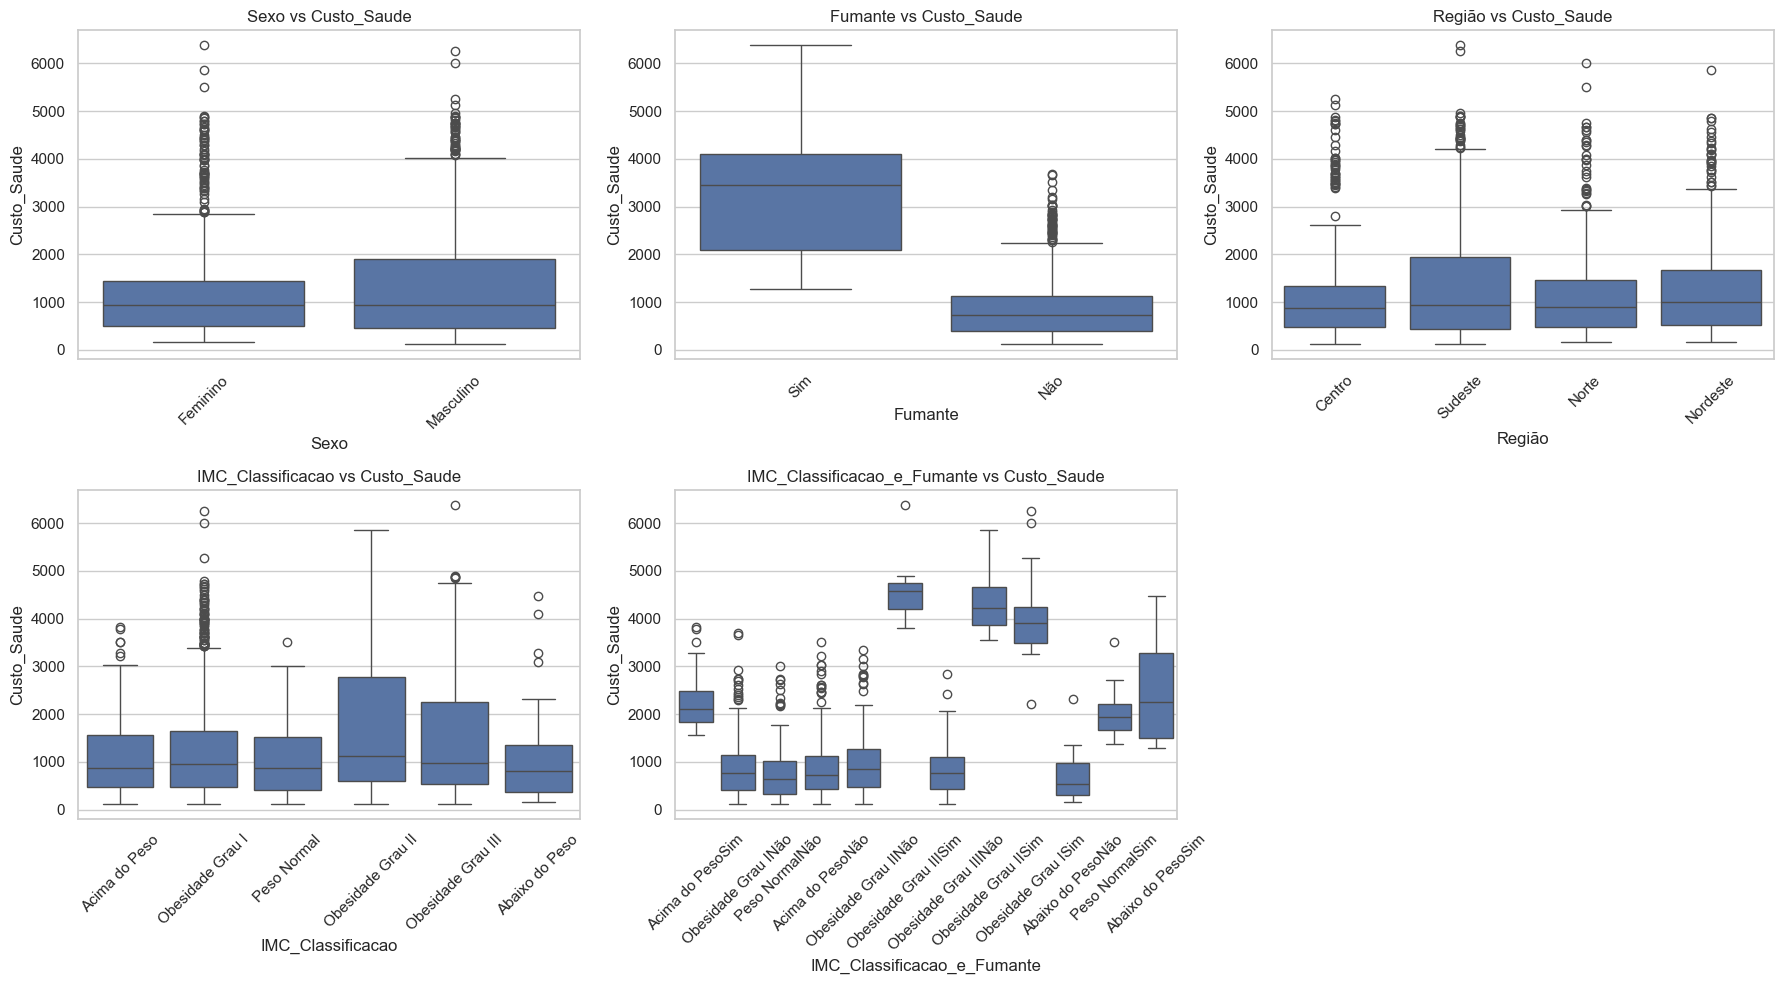

In [27]:
plot_boxplots_categorical_vs_target(df, 'Custo_Saude')

## Inferência com Regressão Linear Múltipla

In [28]:
# Variável resposta
y = df['Custo_Saude']

# Variáveis explicativas
df['intercepto'] = 1
x = df[['intercepto', 'ordem_IMC_e_Fumante_Sim', 'Idade']]

In [29]:
# Ajusta o modelo e retorna os resultados
modelo = sm.OLS(y , x)
resultado = modelo.fit(cov_type='HC3')
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:            Custo_Saude   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     2917.
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        17:39:46   Log-Likelihood:                -10205.
No. Observations:                1338   AIC:                         2.042e+04
Df Residuals:                    1335   BIC:                         2.043e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercepto               -

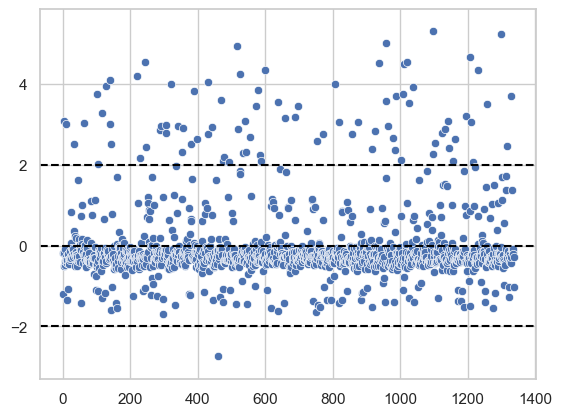

In [30]:
### Residuos
grafico_residuos(resultado)

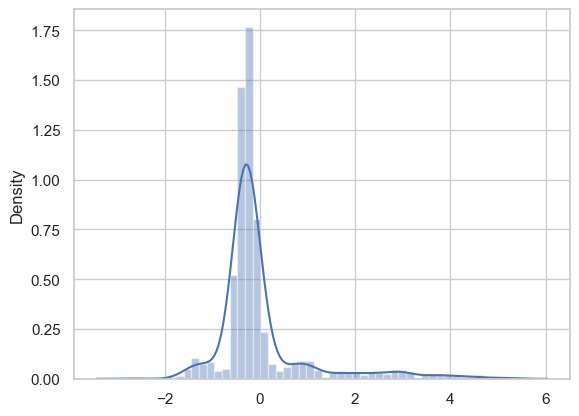

In [31]:
# Construção de histograma para avaliar a distribuição dos resíduos
sns.distplot(resultado.resid_pearson);

In [32]:
# Realização de Teste de Hipóteses para avaliar Normalidade
normalidade = shapiro(resultado.resid_pearson)
print('Estatística=%.3f, p-valor=%.3f\n' % (normalidade.statistic, normalidade.pvalue))

Estatística=0.666, p-valor=0.000



## Homocedasticidade dos Resíduos

In [33]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(resultado.resid_pearson,
                       resultado.model.exog)
print(dict(zip(labels, white_test)))

{'LM Statistic': np.float64(8.239066045760115), 'LM-Test p-value': np.float64(0.1435430935309109), 'F-Statistic': np.float64(1.6505878151072422), 'F-Test p-value': np.float64(0.14366236410318206)}


In [38]:
## Como os valores deram mais que 5% nos testes, não rejeitamos a hipótese nula, portanto consideramos que os resíduos são homocedasticos.

## Salvando novo dataframe para modelagem

In [35]:
df.head(3)

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude,IMC_Classificacao,ordem_IMC,IMC_Classificacao_e_Fumante,Fumante_Sim,ordem_IMC_e_Fumante_Sim,intercepto
0,19,Feminino,27.90,0,Sim,Centro,1688.49240,Acima do Peso,3,Acima do PesoSim,1,3,1
1,18,Masculino,33.77,1,Não,Sudeste,172.55523,Obesidade Grau I,4,Obesidade Grau INão,0,0,1
2,28,Masculino,33.00,3,Não,Sudeste,444.94620,Obesidade Grau I,4,Obesidade Grau INão,0,0,1


In [36]:
df.drop(columns=['IMC_Classificacao', 'Fumante_Sim', 'intercepto', 'IMC_Classificacao_e_Fumante', 'ordem_IMC', 'ordem_IMC_e_Fumante_Sim'], inplace=True)

In [37]:
df.to_parquet('../data/processed/df.parquet')